# Predicting Automation
### UC San Diego SOCI 136 - Final Project
#### Brian Huang

# Abstract

Throughout the Spring Quarter, I've learned a lot about automation, AI, and the effect algorithms have on our society. From bias classification of race to misgendering of language to restructuring the traditional workplace today, AI and automation have had a tremendous impact on society today.

In my final project, I want to investigate and try to predict what features push a job towards being automated. In our investigation, we use a [dataset from Kaggle](https://www.kaggle.com/andrewmvd/occupation-salary-and-likelihood-of-automation) that compiles data from the US Bureau of Labor Statistics, providing us with information such as **Probability**, **Total Employment**, **Mean Annual/Hourly Salary**, and corresponding **Occupation**. We also drew on data from [SmartAsset](https://smartasset.com/checking-account/states-where-jobs-are-most-vulnerable-to-automation) to construct a dictionary of data containing the ranking of states where automation occurs the most.

# Summary of Findings

### Cleaning
Luckily for us, both the `Automation` and `Salary` datasets came relatively clean. The `Automation` dataset had no missing values at all, meaning we did not have to do any sort of imputation. All the data types in the `Automation` dataset were also correct, meaning we did not have to do anything to tidy up our data.

The `Salary` dataset did pose some problems for us. Since the dataset was formatted as an excel file, many values that were missing were filled with either a `*` or a `#`. A lot of the values that were missing were present in the `A_MEDIAN`, `A_PCT75`, and `A_PCT90` columns. This makes sense, as many niche jobs or management jobs tend to lack a median salary or upper bound on salaries. One thing to note is that the three columns are all dependent on each other. If one value is missing, all subsequent values will be missing. For example, if I am missing a value in my `A_MEDIAN`, both `A_PCT75` and `A_PCT90` will also be missing values.

In order to impute our data, we have a few approaches. We could fill them in with zero or drop the data, but both of these options would heavily bias our data. Filling in with zero would bias our salaries lower, while dropping the data is risky as over twenty of our rows having missing values, and dropping all of them would be around `5%` of our data being omitted. 

If we observe the histograms of the distributions of the salaries, we see that for all percentiles, our salary is heavily right skewed:
<br>
![Percentiles Histogram](pct_histograms.png)
<br>
Since it's right skewed for all of our data, we can't apply any sort of normal distrubition imputation. We also can't use a Chi-Squared or Gamma distribution. When we plot our data, we see that it is mostly linear, so our best option for imputing the data is using a Linear Regression model.
<br>
![Data Scatterplot](linear_scatter.png)
<br>

**A note**: We did drop three rows. `Dancers`, `Singers/Musicians`, `Actors`. We dropped these rows as they had no salary data. This makes sense as these roles often receive variable compensation.

Using sklearn, we imputed the missing percentile values:
``` Python
    median_pct25 = LinearRegression()
    X = df.dropna()['A_PCT25'].values.reshape(-1, 1)
    y = df.dropna()['A_MEDIAN']

    median_pct25.fit(X, y)
    median_pct25.score(X, y) 
    
    def median_impute(row):
    if np.isnan(row.A_MEDIAN):
        #check if it is null
        return median_pct25.predict(np.array(row.A_PCT25).reshape(-1, 1))[0]
        #plug in the value we want for our prediction
    else:
        return row.A_MEDIAN
        #if it isn't null keep the original value
        
    df['A_MEDIAN'] = df.apply(median_impute, axis = 1)
    df_with_states['A_MEDIAN'] = df_with_states.apply(median_impute, axis = 1)
    #we're applying column wise
```

## Exploratory Data Analysis
After cleaning our dataset, we're now able to investigate our dataset! Since our main goal is to predict the probability a job title gets automated, we need to take all the unique jobs and find a way to aggregate (group) them together.

My approach to this was to take a given job title, split it into it's word components, and extract the role from that list of words. In order to do this, we split each word into a list and grab the words that end with the letter `'s'`. This is because roles in our dataset tend to end with the letter `'s'` (Managers, Executives, Engineers, Painters, etc). From our list of words ending in the ltter `'s'`, we grab the last word as usually roles come last in a sentence. If we do not have words that end with an `'s'`, we just grab the last word in the list as once again, the last word in a job title tends to be correlated with the job at hand.

For example:
> `Marketing Operations Managers` becomes `['Marketing', 'Managers']`, which when filtered down becomes `['Operations', 'Managers']` which ends up giving us `'Managers'`

When we are missing a word that ends with `'s'`, we get an example like this:
> `Postsecondary Teacher` becomes `['Postsecondary', 'Teacher']`, which ends up giving us `'Teacher'` since we just extract the last word of the sentence.

```Python
    def job_finder(lst):
        '''
        This helper functions takes in a list and checks for
        if a word ends with the letter 's'. It then returns the 
        last word in the list of words that end with 's'.

        If no word ends in 's', it returns the last word in the sentence/list.
        '''
        word = list(filter(lambda x: x.endswith('s'), lst))
        #get a list of words that end with s
        if len(word) != 0:
            return word[-1]
            #if we have words that end with s we return the last word
        else:
            return lst[-1]
            #we just return the last word if it doesn't have 's'
```

Once we have a list of the types of jobs in our dataset, we can group and view some interesting aggregates of our data.

Some interesting plots are:

### The Top 50 Most Common Jobs
![Pie Chart](top_50_jobs.png)
![HBar Chart](most_common_jobs.png)
<br>
### The Probability of Specific Jobs Being Automated
This is sorted in descending order
![Probability Chart](probability.png)

### Top 10 Most Likely to be Automated
![Most Likely](most_likely.png)
### Top 10 Least Likely to be Automated
![Least Likely](least_likely.png)
<br>
**When we look at our data a lot of these probabilities seem accurate.**

`Telemarketers`: The annoying spam callers are without a doubt facing automation, especially with the envoy of new cutting edge speech and NLP AI's. Most advertisement calls, interviewing scheduling calls, and even scam calls are now automated.
<br>
`Appraisers`: Most appraisal can now be done using some sort of Machine Learning Model.
<br>
`Weighers`: We can use AI to weigh a majority of stuff. Electronic Scales, etc.
<br>
`Officials`: For sports, most timing and referee work can be done with cameras that catch images at a high FPS. Most officials tend to be volunteers now (Swimming, Rowing, Soccer, etc).
<br>
`Surgeons`: Although they did do [surgery on a grape](https://www.uchicagomedicine.org/forefront/surgery-articles/they-did-surgery-on-a-grape-and-we-did-a-q-and-a-with-a-surgeon-about-it), we should not expect any automation of surgeons anytime soon.
<br>
`Detectives`: Jobs that require high levels of critical thinking are not likely to face automation anytime soon.
<br>
`Dentists`: Jobs that require fine motors skills or high skill in general are automation safe, for now.
<br>

**Some observations make less sense though:**
<br>
<br>
`Models`: I'm not quite sure how we would automate things such as fashion and runway models. Maybe people enjoy seeing digital versions of their clothes? This left me a bit confused.

## Models and Feature Engineering
When trying to figure out how to predict our data, since we're using salaries and job counts to predict probability, it's likely best for us to use a Regression model. A classifier wouldn't make much sense here. The three types of Regression we're going to try are `LinearRegression()`, `RandomForestRegression()`, and `DecisionTreeRegressor()`.

We also need to select what features we want to use for our baseline model!
<br>
<br>
The features we are dropping are `['SOC', 'OCC_CODE', 'OCC_TITLE', 'OCC_GROUP']`
<br>
<br>
**The reasons why we're dropping each column is:**
<br>
<br>
`SOC`: We're dropping this column. While it is numeric, it's actually a categorical variable that identifies what the unique job is. As so, it will contribute nothing to our model and its predictions.
<br>
<br>
`OCC_CODE`, `OCC_TITLE`, `OCC_GROUP`: Two of these are repeated iterations of `SOC` and `OCCUPATION` left from our inner merge earlier. `OCC_GROUP` is also not very useful as it's just grouping of jobs and their types. We can drop this.


When creating our baseline model, `LinearRegression()` ended up working out the best. Both tree regressors ended up giving very low scores for fitting our model. For the rest of our modeling, we stuck with `LinearRegression()`. The baseline model is attached below.

```Python
    standard_scale = ['TOT_EMP', 'EMP_PRSE', 'A_MEAN', 'MEAN_PRSE', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90']
    ohe = ['Clean Title', 'Occupation']

    preproc = ColumnTransformer(
    transformers = [
        ('standard', StandardScaler(), standard_scale),
        ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
    ])

    pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])
```

Here are the distribution of scores for our baseline model:
```Python
    scores = []
    for _ in range(100):
        f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
        pl.fit(f_train, o_train)
        scores.append(pl.score(f_test, o_test))
    plt.hist(scores)
```
![Baseline Distribution](baseline.png)

The features we engineered to try and improve our model were:
<br>
`Clean Title (OHE)` - This is a one-hot encoded column containing the job title we used to aggregate our jobs on earlier.
<br>
`State Proportions` - This is the proportion of the occupation in each state over the total number of jobs in the United States. Having a proportion lets us know how prevalent a job is in each state. (number of jobs per state/total jobs)
<br>
`Total Economic Contribution` - How much does this job contribute to our GDP? (mean wage * total employees)
<br>
`Median Salary (Binarized)` - A true or false column indicating if Median Salary is greater than what the US considers as upper-middle class salary ($150,000).
<br>
`Most Common State` - A column containing the state where the occupation is most common.
<br>
`Ordinal State Ranking` - A column that ranks states ordinally (drawn from Bureau of labor) and percent risk of automation also from Bureau of labor

For our final model, we were able to improve predictions slightly, but not by much. The final model is attached below:
```Python
    as_is = ['STATE_RANKING', 'STATE_AUTOMATION']
    standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
           'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ECONOMIC_CONTRIBUTION']
    ohe = ['Clean Title', 'Occupation', 'BIGGEST_STATE']
    binarize = ['LARGE_SALARY']
    states = ['Alabama', 'Alaska', 'Arizona',
            'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
            'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
            'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
            'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
            'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
            'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
            'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
            'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
            'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
            'West Virginia', 'Wisconsin', 'Wyoming']

    preproc = ColumnTransformer(
    transformers = [
        #('states', FunctionTransformer(lambda x: x/sum(features_state_df['TOT_EMP'])), states),
        #take the proportion of jobs in the US
        ('binarize', Binarizer(), binarize),
        ('as_is', FunctionTransformer(lambda x: x), as_is),
        ('standard', StandardScaler(), standard_scale),
        ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
    ])

    pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])
```

Here are the distribution of scores for our final model:
```Python
    scores = []
    for _ in range(100):
        f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
        pl.fit(f_train, o_train)
        scores.append(pl.score(f_test, o_test))
    plt.hist(scores)
```
![Final Distribution](final_model.png)

## Conclusions and Findings
Even after extensive feature engineering, we were not able to increase the accuracy of the model by much. With just salary and total number of employees present in the US, we are not able to make consistently accurate predictions of jobs and their probabilites of being automated. The highest accuracy we had was around `50%`, which is not reliable enough for practical application. For future projects, sourcing from more sources to get more data could generate a more reliable prediction model.

In terms of other findings, the dataset itself provided a very insightful look into the jobs that are being automated right now and what the salaries of those jobs and employee count of those jobs look like. We see that mostly white-collar work (low-skill entry, decent salary) jobs are being automated away. High skill jobs tend to be harder to automate, so logically they are the hardest to automate away. Interesingly enough, programming itself is a job that sits in the middle of the automation distribution. It's likely basic programming tasks are slowly being automated away.

Does this mean automation is bad per se? No it doesn't. Automation itself produces new jobs, just as it takes away the old. Automation is inevitable and we shouldn't fight it, but we should take steps to ensure the automation is done in a way ensures the lifestyles of people working in a traditional setting are not uprooted by innovation.

# Code

We start our investigation by importing the neccesary libraries to explore and clean our data.

In [340]:
import pandas as pd #to manipulate dataframes
import numpy as np 
import matplotlib.pyplot as plt #plotting
import os
import seaborn as sns #plotting

This line imports our datasets.

`auto` is a dataframe consisting of the probabilities certain jobs are automated as well as the number of jobs for the listed role present in each state.

`salary` is a dataframe consisting of salary data for each listed role as well as some summary rows. It contains data such as our average hourly and yealy salary, the standard error for each salary, and the different percentiles for each listed job.

In [341]:
auto = pd.read_csv('automation_data_by_state.csv', encoding='cp1252')
salary = pd.read_excel('occupation_salary.xlsx')

In [342]:
auto.head(3)

,SOC,Occupation,Probability,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,11-1011,Chief Executives,0.015,1030,760,5750,2710,31150,880,1410,...,560,5460,5890,3650,280,6320,5910,980,3740,160
1,11-1021,General and Operations Managers,0.160,26930,6490,43300,20680,261780,41540,33280,...,3730,44400,168610,36200,2760,52380,43760,10200,32350,4840
2,11-2011,Advertising and Promotions Managers,0.039,50,40,470,110,3760,480,300,...,0,670,1210,380,40,240,640,40,200,0


In [343]:
salary.head(3)

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,00-0000,All Occupations,total,140400040,0.1,23.86,49630,0.1,9.27,11.6,17.81,28.92,45.45,19290,24140,37040,60150,94540,NaN,NaN
1,11-0000,Management Occupations,major,7090790,0.2,56.74,118020,0.1,22.76,32.99,48.46,70.72,#,47330,68630,100790,147090,#,NaN,NaN
2,11-1000,Top Executives,minor,2465800,0.2,61.03,126950,0.2,20.58,31.45,49.19,78.35,#,42810,65420,102320,162970,#,NaN,NaN


## Cleaning and EDA (Exploratory Data Analysis)

Our data is quite clean to begin with, but we are missing some values indicated by the `#` and `*` symbols. Along side that, it seems we have some duplicates columns as well, and a couple columns with mostly null values. Let's do some investigation into our data and see what we need to clean up to ensure it is workable for our models and exploration.

In [344]:
auto.columns, salary.columns

(Index(['SOC', 'Occupation', 'Probability', 'Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming'],
       dtype='object'),
 Index(['OCC_CODE', 'OCC_TITLE', 'OCC_GROUP', 'TOT_EMP', 'EMP_PRSE', 'H_MEAN',
        'A_MEAN', 'MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75',
        'H_PCT90', 'A_PCT10', 'A_PCT25', 'A_MEDIAN

In [345]:
auto.isnull().mean()

SOC                     0.0
Occupation              0.0
Probability             0.0
Alabama                 0.0
Alaska                  0.0
Arizona                 0.0
Arkansas                0.0
California              0.0
Colorado                0.0
Connecticut             0.0
Delaware                0.0
District of Columbia    0.0
Florida                 0.0
Georgia                 0.0
Hawaii                  0.0
Idaho                   0.0
Illinois                0.0
Indiana                 0.0
Iowa                    0.0
Kansas                  0.0
Kentucky                0.0
Louisiana               0.0
Maine                   0.0
Maryland                0.0
Massachusetts           0.0
Michigan                0.0
Minnesota               0.0
Mississippi             0.0
Missouri                0.0
Montana                 0.0
Nebraska                0.0
Nevada                  0.0
New Hampshire           0.0
New Jersey              0.0
New Mexico              0.0
New York            

In [346]:
salary.isnull().mean()

OCC_CODE     0.000000
OCC_TITLE    0.000000
OCC_GROUP    0.000000
TOT_EMP      0.000000
EMP_PRSE     0.000000
H_MEAN       0.000000
A_MEAN       0.000000
MEAN_PRSE    0.000000
H_PCT10      0.000000
H_PCT25      0.000000
H_MEDIAN     0.000000
H_PCT75      0.000000
H_PCT90      0.000000
A_PCT10      0.000000
A_PCT25      0.000000
A_MEDIAN     0.000000
A_PCT75      0.000000
A_PCT90      0.000000
ANNUAL       0.941176
HOURLY       0.995696
dtype: float64

Looks like our automation dataset is quite clean, there isn't a single null value! Most of the cleaning will be done in our salary dataset it seems. This is possibly due to it being an excel file rather than a csv(comma seperated values) file. We see that the `ANNUAL` and `HOURLY` columns are mostly null, so we can likely drop that data as it may be too difficult for us to impute data in.

Lets merge our two dataframes together, since we know our `auto` dataset is quite clean, we mostly want to keep values in our auto dataset and work with those. Lets do an inner merge to keep values present in both tables. We'll join on `SOC` and `OCC_CODE` as those are the IDs the US Bureau of Labor Statistics uses to classify these jobs.

In [347]:
df = auto.merge(salary, how = 'inner', left_on = 'SOC', right_on = 'OCC_CODE')
df = df.drop(["ANNUAL", "HOURLY"], axis = 1)
df.head(3)

,SOC,Occupation,Probability,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,11-1011,Chief Executives,0.015,1030,760,5750,2710,31150,880,1410,...,33.55,54.86,87.12,#,#,69780,114100,181210,#,#
1,11-1021,General and Operations Managers,0.160,26930,6490,43300,20680,261780,41540,33280,...,21.29,31.2,47.74,74.53,#,44290,64890,99310,155020,#
2,11-2011,Advertising and Promotions Managers,0.039,50,40,470,110,3760,480,300,...,21.61,32.21,48.47,70.98,#,44950,67000,100810,147640,#


Some of these columns have pretty obscure and unintelligble labels, so lets clarify what some of these labels mean:
* `OCC_GROUP` - The category of the size of the group.  Total > Major > Minor > Broad > Detailed
* `EMP_PRSE` - Employment Relative Standard Error (i.e. how accurate the information is with higher numbers being bad)
* `H_MEAN` - Mean hourly wage
* `A_MEAN` - Mean annual wage
* `MEAN_PRSE` - Mean wage Relative Standard Error
* `H_PCT_10` - Hourly wage 10 percentile
* `H_PCT_25` - Hourly wage 25 percentile
* etc..

We've run into our first major issue! A lot of our numerical columns have the dtype of `object`, implying that they're strings and not numeric values. We want to manipulate numeric values, so we will likely need to convert all of the columns that are numeric to int64 or float64.

However, since many of these columns have values missing/filled in with `#` and `*`, we need to either drop those data values, fill them with zero, or find a way to impute them without bias.

In [348]:
df.dtypes

SOC             object
Occupation      object
Probability    float64
Alabama          int64
Alaska           int64
                ...   
A_PCT10         object
A_PCT25         object
A_MEDIAN        object
A_PCT75         object
A_PCT90         object
Length: 72, dtype: object

Since annual and hourly wages are both linearly dependent on each other (as in we can/should be able to calculate and draw the same information from one rather than both), we can drop one of them and work solely with one of them. Lets work with annual salary rather than hourly wages.

In [349]:
df.drop(['H_MEAN','H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75',
        'H_PCT90'], axis = 1, inplace = True)

Let's make a smaller dataframe so we can see our data more clearly as well.

In [350]:
df_with_states = df.copy()

In [351]:
df = df.drop(['Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming'], axis = 1)

Lets investigate what values are missing, indicated by a `*` or a `#`.

In [352]:
df.loc[(df['A_MEAN'] == '*') | (df['A_MEAN'] == '#')]

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
202,27-2011,Actors,0.370,27-2011,Actors,detailed,48620,8.2,*,5.2,*,*,*,*,*
207,27-2031,Dancers,0.130,27-2031,Dancers,detailed,10060,8.3,*,3.6,*,*,*,*,*
210,27-2042,Musicians and Singers,0.074,27-2042,Musicians and Singers,detailed,40110,3.0,*,2.5,*,*,*,*,*


In [353]:
df.loc[(df['A_PCT10'] == '*') | (df['A_PCT10'] == '#')]

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
202,27-2011,Actors,0.370,27-2011,Actors,detailed,48620,8.2,*,5.2,*,*,*,*,*
207,27-2031,Dancers,0.130,27-2031,Dancers,detailed,10060,8.3,*,3.6,*,*,*,*,*
210,27-2042,Musicians and Singers,0.074,27-2042,Musicians and Singers,detailed,40110,3.0,*,2.5,*,*,*,*,*


In [354]:
df.loc[(df['A_PCT25'] == '*') | (df['A_PCT25'] == '#')]

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
202,27-2011,Actors,0.370,27-2011,Actors,detailed,48620,8.2,*,5.2,*,*,*,*,*
207,27-2031,Dancers,0.130,27-2031,Dancers,detailed,10060,8.3,*,3.6,*,*,*,*,*
210,27-2042,Musicians and Singers,0.074,27-2042,Musicians and Singers,detailed,40110,3.0,*,2.5,*,*,*,*,*


In [355]:
df.loc[(df['A_MEDIAN'] == '*') | (df['A_MEDIAN'] == '#')]

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
202,27-2011,Actors,0.3700,27-2011,Actors,detailed,48620,8.2,*,5.2,*,*,*,*,*
207,27-2031,Dancers,0.1300,27-2031,Dancers,detailed,10060,8.3,*,3.6,*,*,*,*,*
210,27-2042,Musicians and Singers,0.0740,27-2042,Musicians and Singers,detailed,40110,3.0,*,2.5,*,*,*,*,*
229,29-1022,Oral and Maxillofacial Surgeons,0.0036,29-1022,Oral and Maxillofacial Surgeons,detailed,5380,9.8,232870,3.8,69550,163110,#,#,#
230,29-1023,Orthodontists,0.0230,29-1023,Orthodontists,detailed,5200,8.6,228780,3.5,91580,150060,#,#,#
235,29-1060,Physicians and Surgeons,0.0042,29-1060,Physicians and Surgeons,broad,649850,0.9,210170,0.6,61870,133450,#,#,#


In [356]:
df.loc[(df['A_PCT75'] == '*') | (df['A_PCT75'] == '#')]

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,11-1011,Chief Executives,0.0150,11-1011,Chief Executives,detailed,223260,0.7,194350,0.4,69780,114100,181210,#,#
202,27-2011,Actors,0.3700,27-2011,Actors,detailed,48620,8.2,*,5.2,*,*,*,*,*
207,27-2031,Dancers,0.1300,27-2031,Dancers,detailed,10060,8.3,*,3.6,*,*,*,*,*
210,27-2042,Musicians and Singers,0.0740,27-2042,Musicians and Singers,detailed,40110,3.0,*,2.5,*,*,*,*,*
228,29-1021,Dentists; General,0.0044,29-1021,"Dentists, General",detailed,105620,1.9,173860,1.2,67690,106180,153900,#,#
229,29-1022,Oral and Maxillofacial Surgeons,0.0036,29-1022,Oral and Maxillofacial Surgeons,detailed,5380,9.8,232870,3.8,69550,163110,#,#,#
230,29-1023,Orthodontists,0.0230,29-1023,Orthodontists,detailed,5200,8.6,228780,3.5,91580,150060,#,#,#
231,29-1024,Prosthodontists,0.0550,29-1024,Prosthodontists,detailed,750,38.3,168140,8.3,74990,98090,126050,#,#
235,29-1060,Physicians and Surgeons,0.0042,29-1060,Physicians and Surgeons,broad,649850,0.9,210170,0.6,61870,133450,#,#,#


In [357]:
df.loc[(df['A_PCT90'] == '*') | (df['A_PCT90'] == '#')]

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,11-1011,Chief Executives,0.0150,11-1011,Chief Executives,detailed,223260,0.7,194350,0.4,69780,114100,181210,#,#
1,11-1021,General and Operations Managers,0.1600,11-1021,General and Operations Managers,detailed,2188870,0.3,122090,0.2,44290,64890,99310,155020,#
2,11-2011,Advertising and Promotions Managers,0.0390,11-2011,Advertising and Promotions Managers,detailed,28860,2.3,117810,1.5,44950,67000,100810,147640,#
3,11-2021,Marketing Managers,0.0140,11-2021,Marketing Managers,detailed,205900,1.0,144140,0.5,67490,93200,131180,178690,#
4,11-2022,Sales Managers,0.0130,11-2022,Sales Managers,detailed,365230,0.6,135090,0.3,55790,79420,117960,168300,#
7,11-3021,Computer and Information Systems Managers,0.0350,11-3021,Computer and Information Systems Managers,detailed,352510,0.9,145740,0.4,82360,105290,135800,170670,#
8,11-3031,Financial Managers,0.0690,11-3031,Financial Managers,detailed,543300,0.6,139720,0.3,65000,87530,121750,168790,#
25,11-9121,Natural Sciences Managers,0.0180,11-9121,Natural Sciences Managers,detailed,54780,2.2,136150,1.4,66920,92070,119850,160990,#
52,13-2052,Personal Financial Advisors,0.5800,13-2052,Personal Financial Advisors,detailed,201850,1.4,123100,1.0,41160,57460,90530,160490,#
93,17-2171,Petroleum Engineers,0.1600,17-2171,Petroleum Engineers,detailed,32780,5.0,147030,1.3,73000,97430,128230,179450,#


With the exception of three occupations, `Actors`, `Dancers`, and `Singers/Musicians`, most of our data is missing an upper percentile. This makes sense as often times higher wages are more difficult to calculate since they are more sparsely reported. We will likely need to drop `Actors`, `Dancers`, and `Singers/Musicians` as we simply do not have enough data to use those rows. We need to investigate how we could impute these missing values (Median, 75th, 90th Percentile)

In [358]:
#lets replace the * and # with np.NaNs
df.replace('#', np.NaN, inplace = True)
df.replace('*', np.NaN, inplace = True)
df_with_states.replace('#', np.NaN, inplace = True)
df_with_states.replace('*', np.NaN, inplace = True)

In [359]:
df.dtypes

SOC             object
Occupation      object
Probability    float64
OCC_CODE        object
OCC_TITLE       object
OCC_GROUP       object
TOT_EMP          int64
EMP_PRSE       float64
A_MEAN         float64
MEAN_PRSE      float64
A_PCT10        float64
A_PCT25        float64
A_MEDIAN       float64
A_PCT75        float64
A_PCT90        float64
dtype: object

In [360]:
#now we can plot these better since they are all floats and ints
df = df.astype({'A_MEAN': 'float64', 
           'A_PCT10': 'float64', 
           'A_PCT25': 'float64', 
           'A_MEDIAN': 'float64', 
           'A_PCT75': 'float64', 
           'A_PCT90': 'float64'})
df.dtypes

SOC             object
Occupation      object
Probability    float64
OCC_CODE        object
OCC_TITLE       object
OCC_GROUP       object
TOT_EMP          int64
EMP_PRSE       float64
A_MEAN         float64
MEAN_PRSE      float64
A_PCT10        float64
A_PCT25        float64
A_MEDIAN       float64
A_PCT75        float64
A_PCT90        float64
dtype: object

In [361]:
df = df.loc[~df['Occupation'].isin(['Actors', 'Musicians and Singers', 'Dancers'])]
df_with_states = df_with_states.loc[~df_with_states['Occupation'].isin(['Actors', 'Musicians and Singers', 'Dancers'])]
#drop our Actors, Singers/Musicians, and Dancers
df.reset_index(inplace = True, drop = True)
df_with_states.reset_index(inplace = True, drop = True)

<AxesSubplot:title={'center':'90th Percentile'}, ylabel='Frequency'>

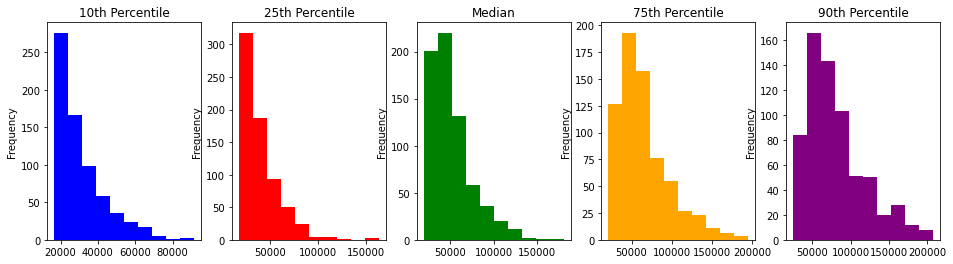

In [362]:
fig, axes = plt.subplots(1, 5, figsize=(16,4))

df['A_PCT10'].plot(kind = 'hist', ax=axes[0], title='10th Percentile', color = 'blue')
df['A_PCT25'].plot(kind = 'hist', ax=axes[1], title='25th Percentile', color = 'red')
df['A_MEDIAN'].plot(kind = 'hist', ax=axes[2], title='Median', color = 'green')
df['A_PCT75'].plot(kind = 'hist', ax=axes[3], title='75th Percentile', color = 'orange')
df['A_PCT90'].plot(kind = 'hist', ax=axes[4], title='90th Percentile', color = 'purple')

In [363]:
df.isnull().mean()

SOC            0.000000
Occupation     0.000000
Probability    0.000000
OCC_CODE       0.000000
OCC_TITLE      0.000000
OCC_GROUP      0.000000
TOT_EMP        0.000000
EMP_PRSE       0.000000
A_MEAN         0.000000
MEAN_PRSE      0.000000
A_PCT10        0.000000
A_PCT25        0.000000
A_MEDIAN       0.004380
A_PCT75        0.008759
A_PCT90        0.029197
dtype: float64

Our data is missing at random (MAR) depedent on previous percentile columns. If we look at our data, any column missing the previous percentile (say the median), will be missing all subsequent percentiles (75th, 90th).

Lets see if we can impute the data using linear regression.

/Users/brianhuang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/brianhuang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='A_PCT90', ylabel='A_MEDIAN'>

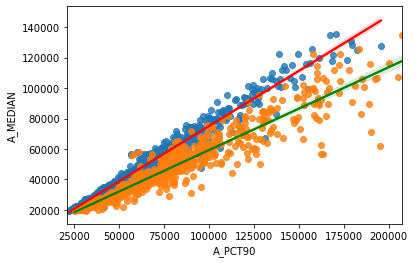

In [364]:
sns.regplot(df['A_PCT75'], df['A_MEDIAN'], line_kws={"color": "red"})
sns.regplot(df['A_PCT90'], df['A_MEDIAN'], line_kws={"color": "green"})

Our data is in fact **linear**!

In [365]:
from sklearn.linear_model import LinearRegression

In [366]:
median_pct10 = LinearRegression()
X = df.dropna()['A_MEDIAN'].values.reshape(-1, 1)
y = df.dropna()['A_PCT10']

median_pct10.fit(X, y)
median_pct10.score(X, y)

0.9096855513608675

This linear regression model using the 10th percentile has a score of `90%`, which is lower than when we regress against the 25th percentile, so we will use the 25th percentile to impute our data!

### Impute our Median

In [367]:
median_pct25 = LinearRegression()
X = df.dropna()['A_PCT25'].values.reshape(-1, 1)
y = df.dropna()['A_MEDIAN']

median_pct25.fit(X, y)
median_pct25.score(X, y)

0.9716513598120117

In [368]:
def median_impute(row):
    if np.isnan(row.A_MEDIAN):
        #check if it is null
        return median_pct25.predict(np.array(row.A_PCT25).reshape(-1, 1))[0]
        #plug in the value we want for our prediction
    else:
        return row.A_MEDIAN
        #if it isn't null keep the original value

In [369]:
df['A_MEDIAN'] = df.apply(median_impute, axis = 1)
df_with_states['A_MEDIAN'] = df_with_states.apply(median_impute, axis = 1)
#we're applying column wise

In [370]:
df['A_MEDIAN'].isnull().mean()

0.0

### Impute our 75th Percentile

We've filled in the null values for all our median values. We can use that to regress on our 75th percentile now.

In [181]:
pct75_median = LinearRegression()
X = df.dropna()['A_MEDIAN'].values.reshape(-1, 1)
y = df.dropna()['A_PCT75']

pct75_median.fit(X, y)
pct75_median.score(X, y)

0.9694471291503226

In [182]:
def pct75_impute(row):
    if np.isnan(row.A_PCT75):
        #check if it is null
        return pct75_median.predict(np.array(row.A_MEDIAN).reshape(-1, 1))[0]
        #plug in the value we want for our prediction
    else:
        return row.A_PCT75
        #if it isn't null keep the original value

In [371]:
df['A_PCT75'] = df.apply(pct75_impute, axis = 1)
df_with_states['A_PCT75'] = df_with_states.apply(pct75_impute, axis = 1)
#we're applying column wise

In [372]:
df['A_PCT75'].isnull().mean()

0.0

### Impute our 90th Percentile

In [373]:
pct90_median = LinearRegression()
X = df.dropna()['A_MEDIAN'].values.reshape(-1, 1)
y = df.dropna()['A_PCT90']

pct90_median.fit(X, y)
pct90_median.score(X, y)

0.8840707862523232

In [374]:
pct90_pct75 = LinearRegression()
X = df.dropna()['A_PCT75'].values.reshape(-1, 1)
y = df.dropna()['A_PCT90']

pct90_pct75.fit(X, y)
pct90_pct75.score(X, y)

0.9599652528485136

In [375]:
def pct90_impute(row):
    if np.isnan(row.A_PCT90):
        #check if it is null
        return pct90_pct75.predict(np.array(row.A_PCT75).reshape(-1, 1))[0]
        #plug in the value we want for our prediction
    else:
        return row.A_PCT90
        #if it isn't null keep the original value

In [376]:
df['A_PCT90'] = df.apply(pct90_impute, axis = 1)
df_with_states['A_PCT90'] = df_with_states.apply(pct90_impute, axis = 1)
#we're applying column wise

In [377]:
df['A_PCT90'].isnull().mean()

0.0

All our null values should be cleaned now! Data types should also be correct!

In [378]:
df.isnull().mean(), df.dtypes

(SOC            0.0
 Occupation     0.0
 Probability    0.0
 OCC_CODE       0.0
 OCC_TITLE      0.0
 OCC_GROUP      0.0
 TOT_EMP        0.0
 EMP_PRSE       0.0
 A_MEAN         0.0
 MEAN_PRSE      0.0
 A_PCT10        0.0
 A_PCT25        0.0
 A_MEDIAN       0.0
 A_PCT75        0.0
 A_PCT90        0.0
 dtype: float64,
 SOC             object
 Occupation      object
 Probability    float64
 OCC_CODE        object
 OCC_TITLE       object
 OCC_GROUP       object
 TOT_EMP          int64
 EMP_PRSE       float64
 A_MEAN         float64
 MEAN_PRSE      float64
 A_PCT10        float64
 A_PCT25        float64
 A_MEDIAN       float64
 A_PCT75        float64
 A_PCT90        float64
 dtype: object)

Lets explore some of our data now that it's all cleaned up! The first question we should investigate is what jobs or rather job titles are most frequent in our dataset? Is there a way for us to group the data so that we can investigate if certain types of jobs are more prone to automation? 

The dataset presents us with a unique set of job titles so we'll need to do some cleaning to aggregate certain jobs together. In our set we see many forms of managers, executives, engineers, etc. Lets see if we can create a column that we can use to group all of this data together.

In [621]:
def job_finder(lst):
    '''
    This helper functions takes in a list and checks for
    if a word ends with the letter 's'. It then returns the 
    last word in the list of words that end with 's'.
    
    If no word ends in 's', it returns the last word in the sentence/list.
    '''
    word = list(filter(lambda x: x.endswith('s'), lst))
    #get a list of words that end with s
    if len(word) != 0:
        return word[-1]
        #if we have words that end with s we return the last word
    else:
        return lst[-1]
        #we just return the last word if it doesn't have 's'

In [577]:
common_words = df['Occupation'].str.replace(';',"").str.split().apply(job_finder)
#pull all our occupations, strip them into individual words, split them into a list, and apply our function
common_words.head(10)

0    Executives
1      Managers
2      Managers
3      Managers
4      Managers
5      Managers
6      Managers
7      Managers
8      Managers
9      Managers
Name: Occupation, dtype: object

The two plots below display the frequency of the most common jobs. We imagine that jobs with more frequency are more prone to automation as they tend to be white-collar work (easy entry with low education). We can also see some older jobs may be prone to automation in our plot following these two plots.

<AxesSubplot:>

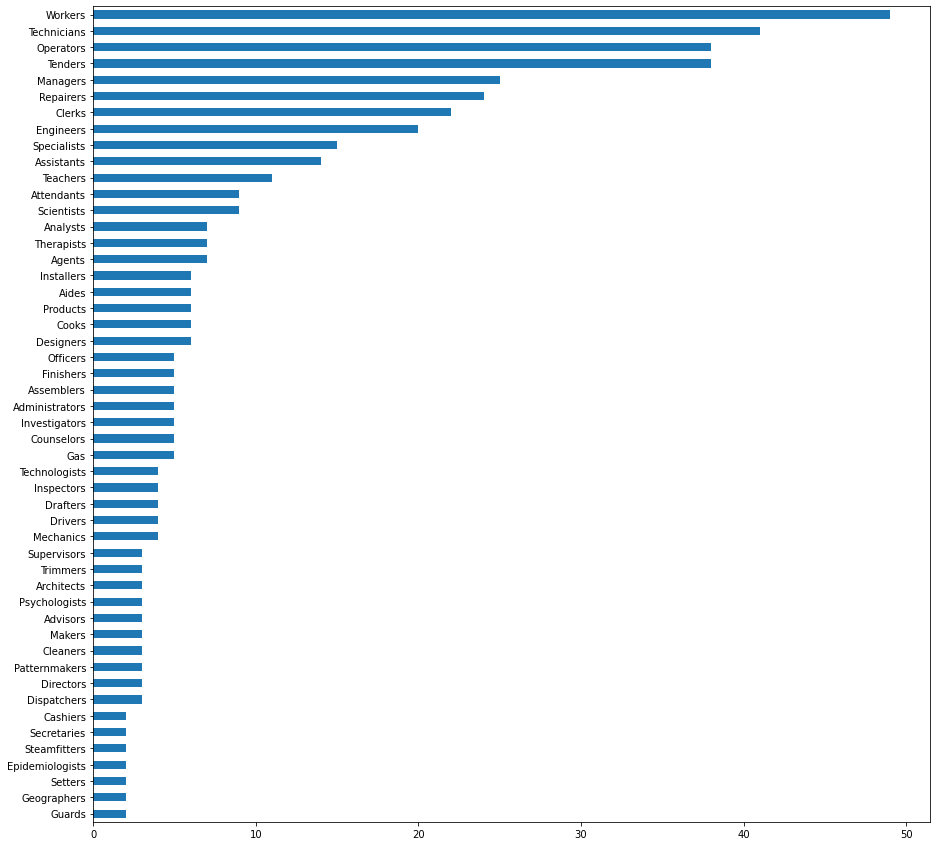

In [381]:
common_words.value_counts().head(50).sort_values().plot(kind = 'barh', figsize = (15, 15))

<AxesSubplot:ylabel='Occupation'>

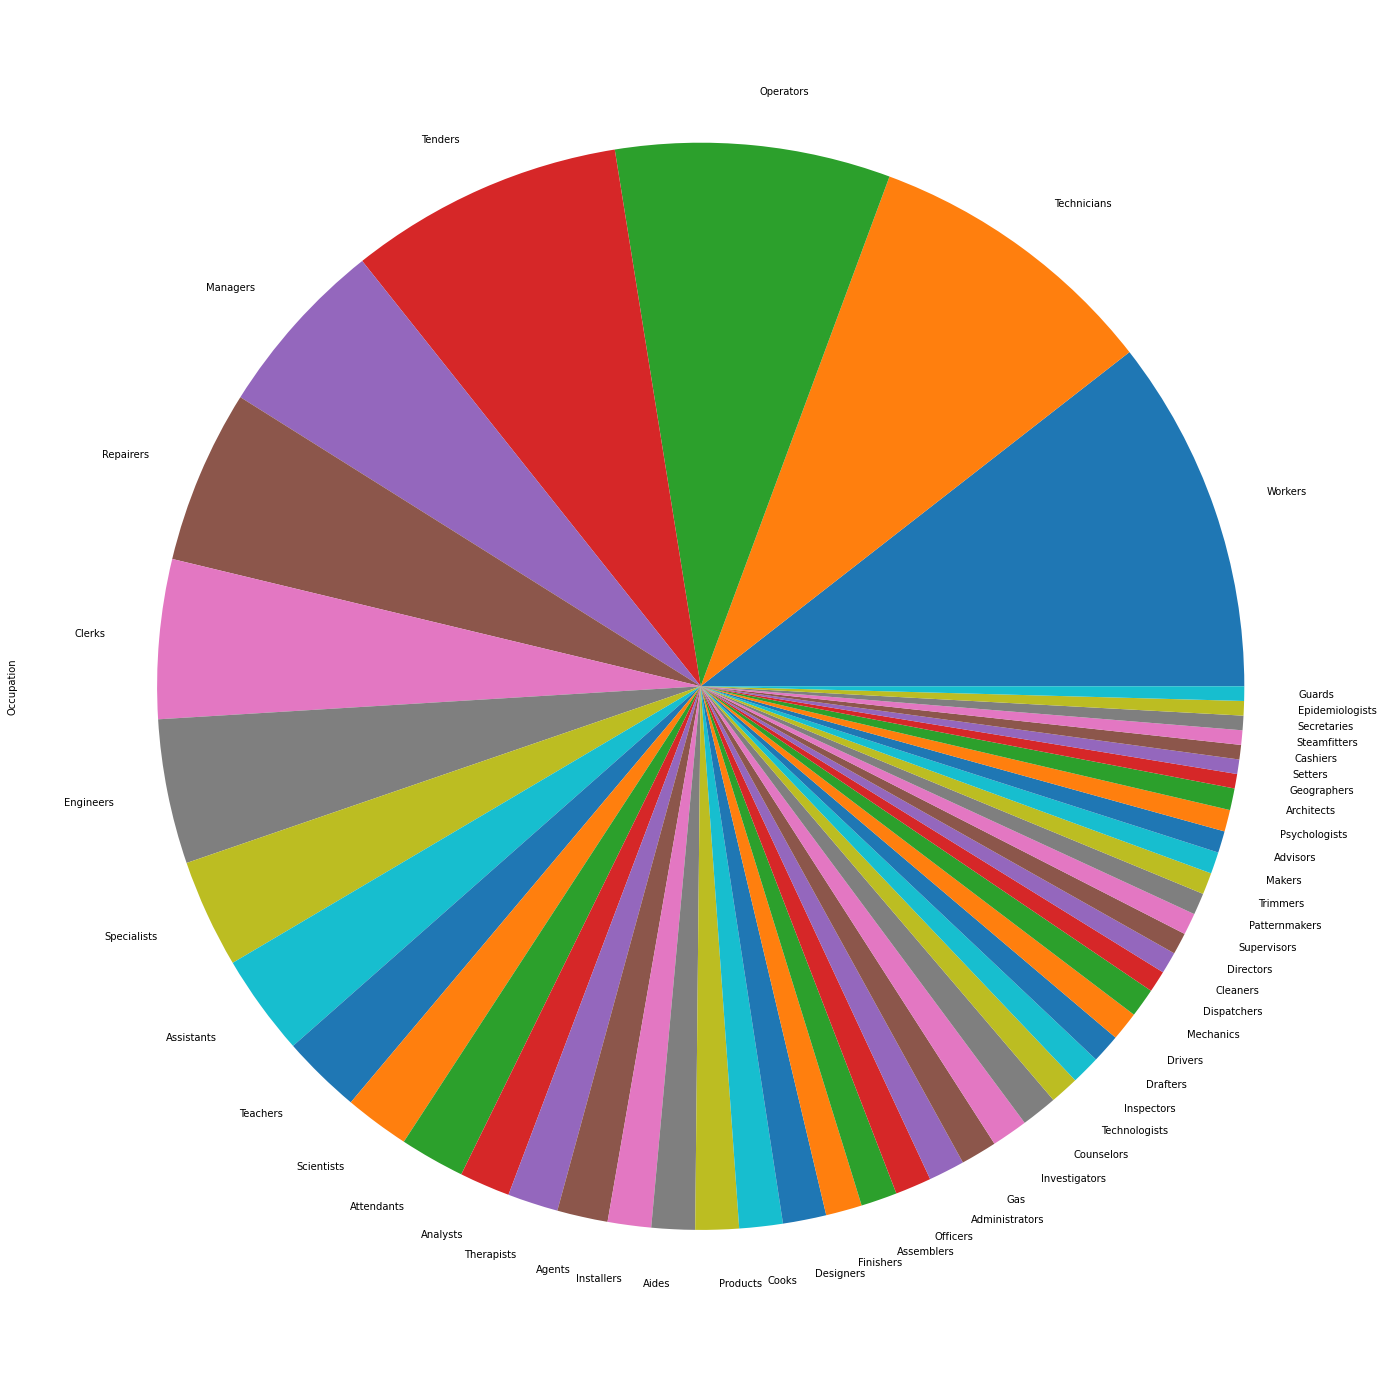

In [382]:
common_words.value_counts().head(50).plot(kind = 'pie', figsize = (25, 25))

This horizontal bar graph shows the probability of each grouped job title being automated, sorted in descending order (largest to smallest).

<AxesSubplot:ylabel='Clean Title'>

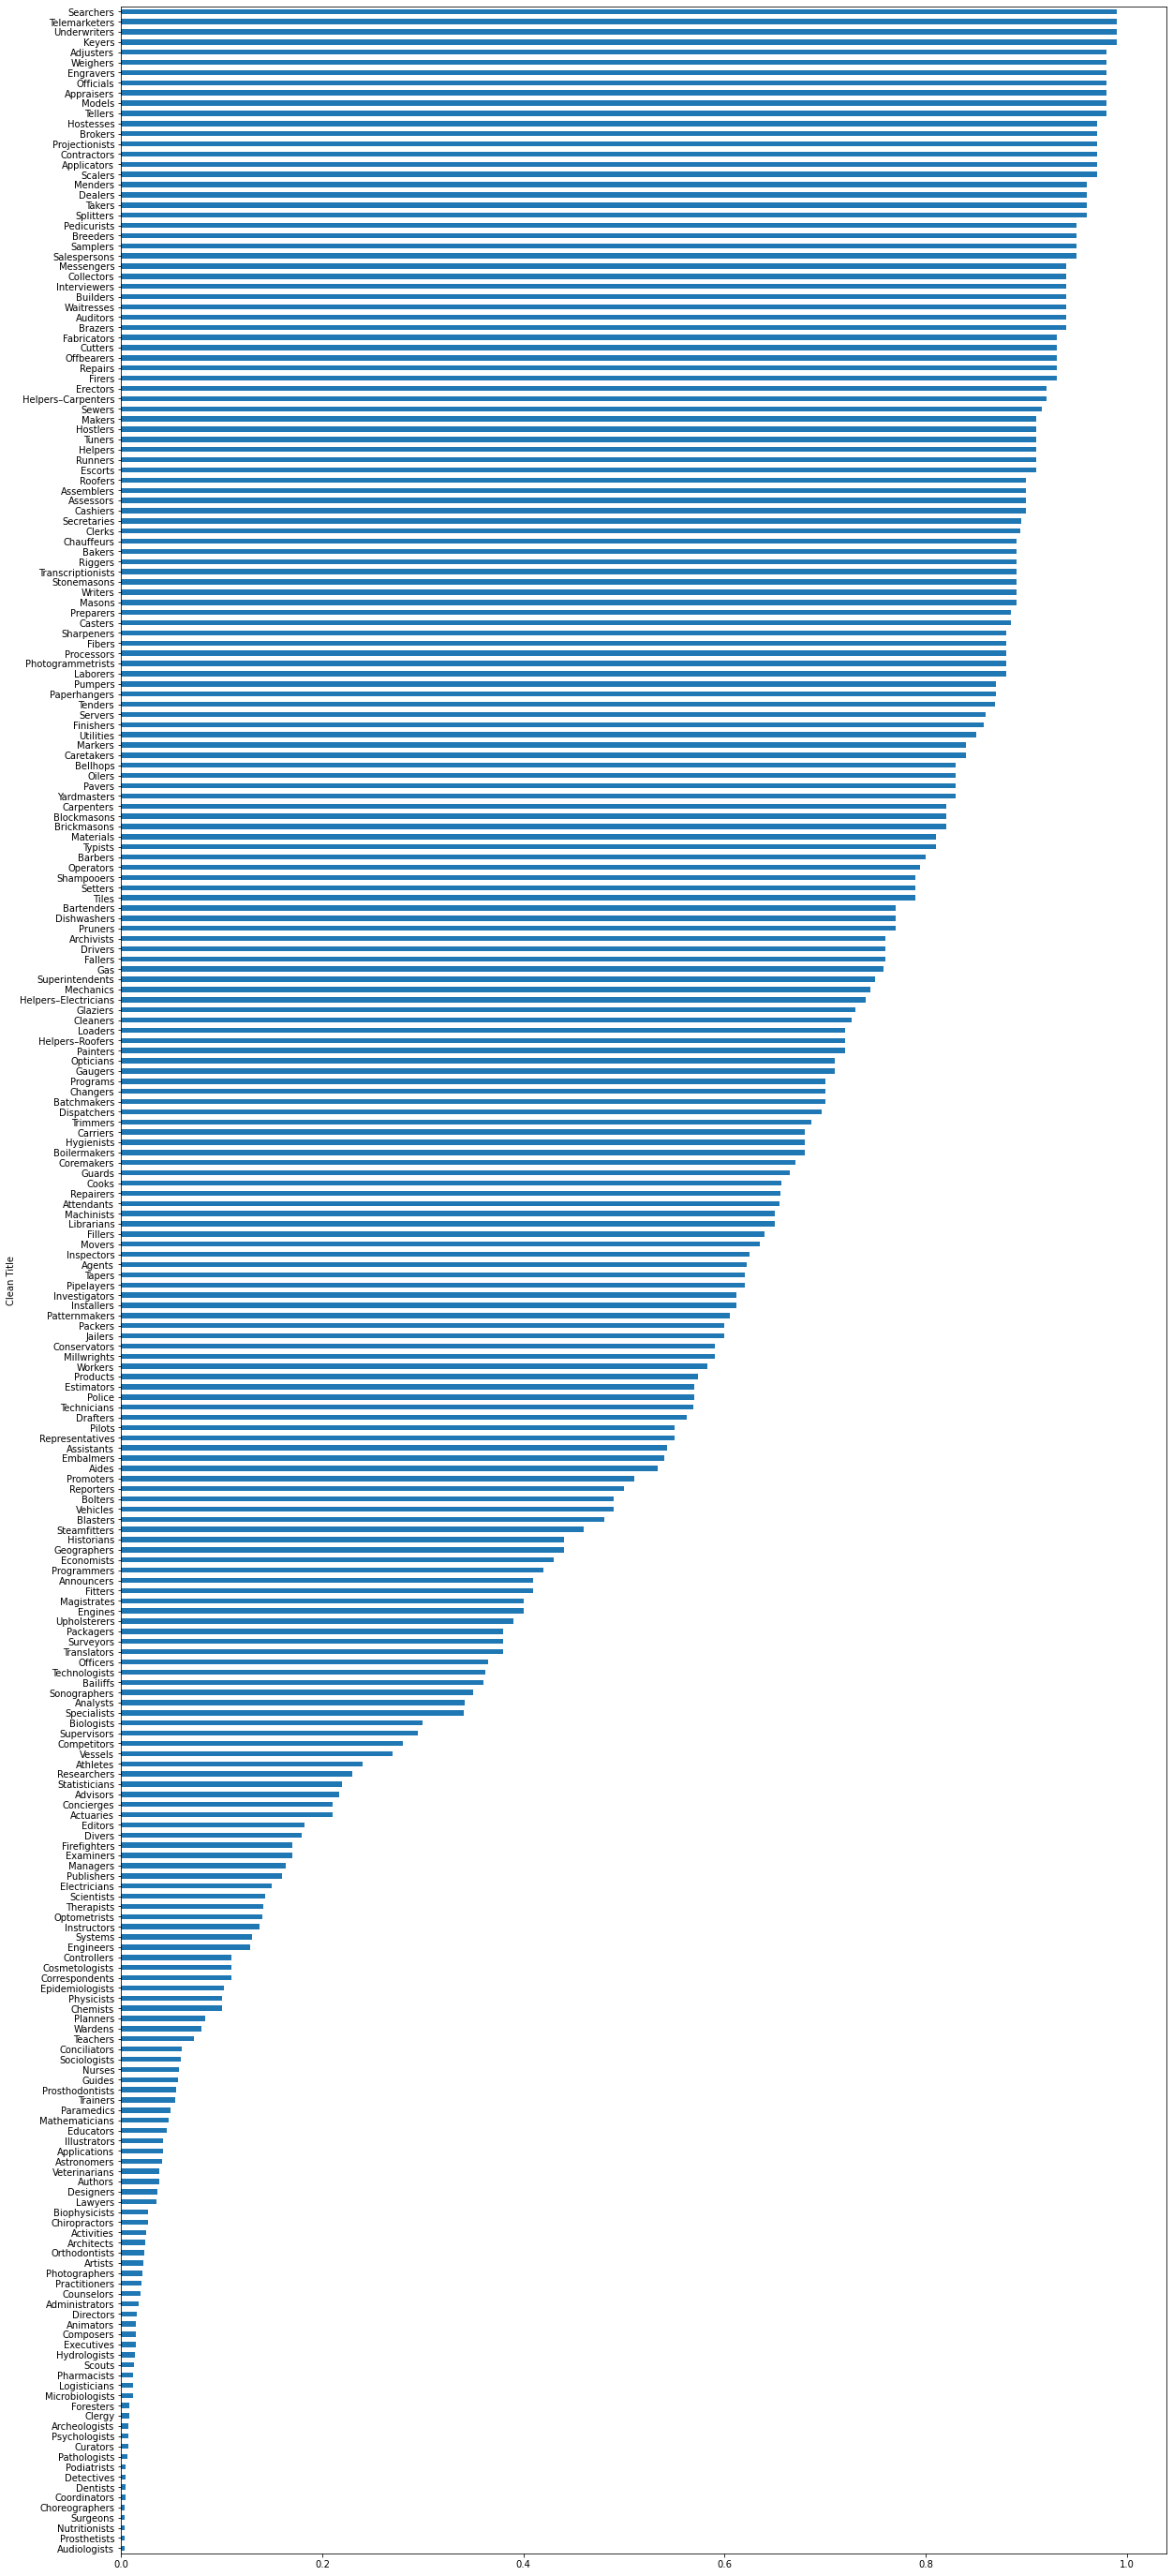

In [384]:
df['Clean Title'] = common_words
df_with_states['Clean Title'] = common_words
df.groupby('Clean Title')['Probability'].mean().sort_values().plot(kind = 'barh', figsize = (20, 50))

In [196]:
df.groupby('Clean Title')['Probability'].mean().sort_values(ascending = False).head(10).to_frame()
#jobs with the highest likelihood of being automated

,Probability
Clean Title,
Searchers,0.99
Telemarketers,0.99
Underwriters,0.99
Keyers,0.99
Adjusters,0.98
Weighers,0.98
Engravers,0.98
Officials,0.98
Appraisers,0.98


In [197]:
df.groupby('Clean Title')['Probability'].mean().sort_values(ascending = False).tail(10).to_frame()
#jobs that are least likely to be automated

,Probability
Clean Title,
Pathologists,0.0064
Podiatrists,0.0046
Detectives,0.0044
Dentists,0.0044
Coordinators,0.0042
Choreographers,0.0040
Surgeons,0.0039
Nutritionists,0.0039
Prosthetists,0.0035


## Prediction Model

Before we create our prediction model, we need to decide which features we're going to use, what features we are going to engineer, and how we're going to deal with categorical features.

In [198]:
df.head()

,SOC,Occupation,Probability,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,Clean Title
0,11-1011,Chief Executives,0.015,11-1011,Chief Executives,detailed,223260,0.7,194350.0,0.4,69780.0,114100.0,181210.0,234946.313352,301332.865256,Executives
1,11-1021,General and Operations Managers,0.160,11-1021,General and Operations Managers,detailed,2188870,0.3,122090.0,0.2,44290.0,64890.0,99310.0,155020.000000,198527.431365,Managers
2,11-2011,Advertising and Promotions Managers,0.039,11-2011,Advertising and Promotions Managers,detailed,28860,2.3,117810.0,1.5,44950.0,67000.0,100810.0,147640.000000,189034.886666,Managers
3,11-2021,Marketing Managers,0.014,11-2021,Marketing Managers,detailed,205900,1.0,144140.0,0.5,67490.0,93200.0,131180.0,178690.000000,228973.032046,Managers
4,11-2022,Sales Managers,0.013,11-2022,Sales Managers,detailed,365230,0.6,135090.0,0.3,55790.0,79420.0,117960.0,168300.000000,215608.866813,Managers


In [396]:
features_df = df.drop(['SOC', 'OCC_CODE', 'OCC_TITLE', 'OCC_GROUP'], axis = 1)
features_state_df = df_with_states.drop(['SOC', 'OCC_CODE', 'OCC_TITLE', 'OCC_GROUP'], axis = 1)

The features we are dropping are `['SOC', 'OCC_CODE', 'OCC_TITLE', 'OCC_GROUP']`
<br>
<br>
**The reasons why we're dropping each column is:**
<br>
<br>
`SOC`: We're dropping this column. While it is numeric, it's actually a categorical variable that identifies what the unique job is. As so, it will contribute nothing to our model and its predictions.
<br>
<br>
`OCC_CODE`, `OCC_TITLE`, `OCC_GROUP`: Two of these are repeated iterations of `SOC` and `OCCUPATION` left from our inner merge earlier. `OCC_GROUP` is also not very useful as it's just grouping of jobs and their types. We can drop this.

In [561]:
from sklearn.pipeline import Pipeline
#create our pipelines
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
#ohe our categorical column
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
#scale our numerical variables
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#assemble our models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#ensure fairness in our models (no overfitting or bias)
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

### Baseline Model
We use our baseline model to compare against any future model we make.

In [578]:
outcome = df['Probability']
features = features_df.drop('Probability', axis = 1)

In [618]:
standard_scale = ['TOT_EMP', 'EMP_PRSE', 'A_MEAN', 'MEAN_PRSE', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90']
ohe = ['Clean Title', 'Occupation']

preproc = ColumnTransformer(
transformers = [
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [619]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.4244483399556953

In [611]:
mean_squared_error(o_test, pl.predict(f_test), squared = False)

0.2758217172210338

In [584]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))

(array([ 3.,  1.,  4., 12., 25., 29., 12.,  8.,  5.,  1.]),
 array([0.26574075, 0.29300574, 0.32027073, 0.34753573, 0.37480072,
        0.40206572, 0.42933071, 0.45659571, 0.4838607 , 0.5111257 ,
        0.53839069]),
 <BarContainer object of 10 artists>)

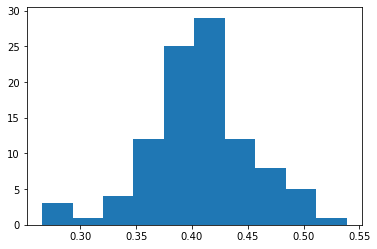

In [585]:
plt.hist(scores)

As we can see, our baseline model is not very good right now. Our scores are also highly variant. What features can we engineer to improve our model as it is now?

### Model Selection

In [403]:
outcome = df['Probability']
features = features_df.drop('Probability', axis = 1)

In [404]:
features_df.head(5)

,Occupation,Probability,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,Clean Title
0,Chief Executives,0.015,223260,0.7,194350.0,0.4,69780.0,114100.0,181210.0,234946.313352,301332.865256,Executives
1,General and Operations Managers,0.160,2188870,0.3,122090.0,0.2,44290.0,64890.0,99310.0,155020.000000,198527.431365,Managers
2,Advertising and Promotions Managers,0.039,28860,2.3,117810.0,1.5,44950.0,67000.0,100810.0,147640.000000,189034.886666,Managers
3,Marketing Managers,0.014,205900,1.0,144140.0,0.5,67490.0,93200.0,131180.0,178690.000000,228973.032046,Managers
4,Sales Managers,0.013,365230,0.6,135090.0,0.3,55790.0,79420.0,117960.0,168300.000000,215608.866813,Managers


In [405]:
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90']
ohe = ['Clean Title', 'Occupation']

preproc = ColumnTransformer(
transformers = [
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [406]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))

(array([ 1.,  3.,  5.,  6., 15., 24., 18., 15.,  8.,  5.]),
 array([0.25212405, 0.27875092, 0.30537779, 0.33200466, 0.35863152,
        0.38525839, 0.41188526, 0.43851213, 0.465139  , 0.49176586,
        0.51839273]),
 <BarContainer object of 10 artists>)

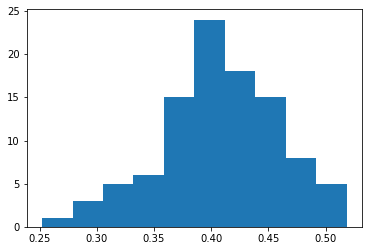

In [407]:
plt.hist(scores)

In [408]:
standard_scale = ['TOT_EMP', 'EMP_PRSE', 'A_MEAN', 'MEAN_PRSE', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90']
ohe = ['Clean Title', 'Occupation']

preproc = ColumnTransformer(
transformers = [
    ('as_is', FunctionTransformer(lambda x: x), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [409]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))

(array([ 2.,  2.,  8., 17., 18., 20., 16.,  9.,  5.,  3.]),
 array([0.27001912, 0.29519262, 0.32036612, 0.34553962, 0.37071313,
        0.39588663, 0.42106013, 0.44623363, 0.47140713, 0.49658064,
        0.52175414]),
 <BarContainer object of 10 artists>)

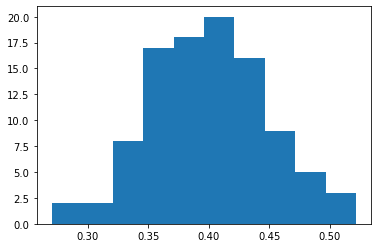

In [410]:
plt.hist(scores)

In [411]:
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90']
ohe = ['Clean Title', 'Occupation']

preproc = ColumnTransformer(
transformers = [
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', RandomForestRegressor(max_depth = 5))])

In [412]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.19903510317935946

(array([ 4.,  4.,  6., 14., 17., 13., 20., 13.,  6.,  3.]),
 array([0.22907865, 0.25402081, 0.27896297, 0.30390513, 0.32884729,
        0.35378944, 0.3787316 , 0.40367376, 0.42861592, 0.45355808,
        0.47850023]),
 <BarContainer object of 10 artists>)

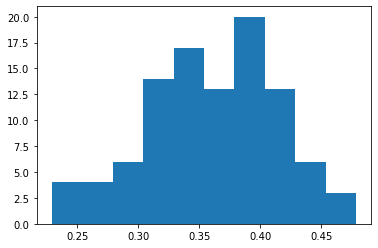

In [413]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))
plt.hist(scores)

Looks like our best bet for a model is going to be sticking with LinearRegression models. All the Decision Tree regressors are having issues with default max_depth, so its best to stick with what we know best.

### Feature Engineering

In [414]:
features_df["ECONOMIC_CONTRIBUTION"] = features_df['A_MEAN'] * features_df['TOT_EMP']
features_state_df["ECONOMIC_CONTRIBUTION"] = features_df['A_MEAN'] * features_df['TOT_EMP']
features_df.head(1)

,Occupation,Probability,TOT_EMP,EMP_PRSE,A_MEAN,MEAN_PRSE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,Clean Title,ECONOMIC_CONTRIBUTION
0,Chief Executives,0.015,223260,0.7,194350.0,0.4,69780.0,114100.0,181210.0,234946.313352,301332.865256,Executives,4.339058e+10


The amount a job contributes to the economy could factor in to how likely it is or isn't to be automated, so let's calculate how much each job adds to the economy in terms of workers being paid and money being put back into the circulation.

In [284]:
outcome = df['Probability']
features = features_df.drop('Probability', axis = 1)

In [285]:
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ECONOMIC_CONTRIBUTION']
ohe = ['Clean Title', 'Occupation']

preproc = ColumnTransformer(
transformers = [
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [286]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.42815925038702685

(array([ 1.,  3.,  6., 11., 19., 20., 17., 12., 10.,  1.]),
 array([0.2552347 , 0.28225767, 0.30928063, 0.33630359, 0.36332656,
        0.39034952, 0.41737248, 0.44439545, 0.47141841, 0.49844137,
        0.52546434]),
 <BarContainer object of 10 artists>)

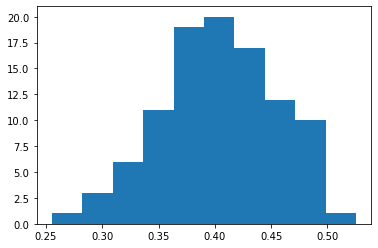

In [622]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))
plt.hist(scores)

Another thing we could consider is that very high salaries could be for high-skill jobs that are not likely to be automated. Let's add a column that is the binarized form of our median annual salary. We're using the median as it is more considerate of outliers, which are heavily present in wages (think about how some people make very large salaries and bias our mean).

In [623]:
features_df['LARGE_SALARY'] = features_df['A_MEDIAN'] > 150000
features_state_df['LARGE_SALARY'] = features_df['A_MEDIAN'] > 150000

In [624]:
outcome = df['Probability']
features = features_df.drop('Probability', axis = 1)

In [625]:
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ECONOMIC_CONTRIBUTION']
ohe = ['Clean Title', 'Occupation']
binarize = ['LARGE_SALARY']

preproc = ColumnTransformer(
transformers = [
    ('binarize', Binarizer(), binarize),
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [626]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.3715094708644727

(array([ 3.,  6.,  4., 20., 16., 14., 19.,  6.,  8.,  4.]),
 array([0.32198325, 0.34025765, 0.35853206, 0.37680646, 0.39508086,
        0.41335527, 0.43162967, 0.44990407, 0.46817848, 0.48645288,
        0.50472728]),
 <BarContainer object of 10 artists>)

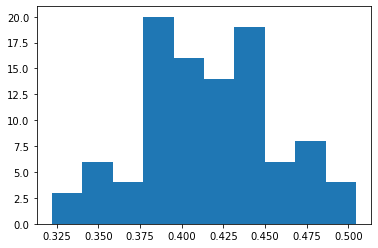

In [627]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)
    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))
plt.hist(scores)

Lets see if adding data about the states impacts how our model predicts information.

In [628]:
outcome = features_state_df['Probability']
features = features_state_df.drop('Probability', axis = 1)

In [629]:
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ECONOMIC_CONTRIBUTION', 'Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming']
ohe = ['Clean Title', 'Occupation']
binarize = ['LARGE_SALARY']

preproc = ColumnTransformer(
transformers = [
    ('binarize', Binarizer(), binarize),
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [630]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.4164919615092717

No change it seems. Let's see if we can engineer the states columns to give us more data about our set. We'll start by engineering a column that gives us the state where each job is most present. We can use that column to also engineer another column giving us an ordinal ranking of if a state is highly likely to have jobs automated (1) or very unlikely (50).

In [631]:
features_state_df[['Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming']] = features_state_df[['Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming']]/sum(features_state_df['TOT_EMP'])
#get the percent of jobs present in each state

In [632]:
features_state_df["BIGGEST_STATE"] = features_state_df[['Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming']].idxmax(axis = 1)
#grab the state which has the most of this specific occupation

In [633]:
features_state_df[['Occupation', 'BIGGEST_STATE']]['BIGGEST_STATE']

0         California
1         California
2           New York
3         California
4         California
           ...      
680            Texas
681            Texas
682       California
683    West Virginia
684            Texas
Name: BIGGEST_STATE, Length: 685, dtype: object

In [634]:
#this data is sourced from smartasset, which sourced its data from the US Bureau of Labor
#https://smartasset.com/checking-account/states-where-jobs-are-most-vulnerable-to-automation
states = {'Nevada': 1, 
          'South Dakota': 2, 
          'Wyoming': 3, 
          'Louisiana': 4, 
          'Montana': 5, 
          'South Carolina': 6, 
          'Mississippi': 7, 
          'Florida': 8, 
          'Texas': 9, 
          'Alabama': 10,
          'West Virginia': 11,
          'Oklahoma': 12,
          'Idaho': 13,
          'Hawaii': 14,
          'Arkansas': 15,
          'North Dakota': 16,
          'Missouri': 17,
          'Wisconsin': 18,
          'Indiana': 19,
          'Kansas': 20,
          'Nebraska': 21,
          'Iowa': 22,
          'New Mexico': 23,
          'Tennessee': 24,
          'Kentucky': 25,
          'Pennsylvania': 26,
          'Maine': 27,
          'Delaware': 28,
          'Georgia': 29,
          'North Carolina': 30,
          'New Hampshire': 31,
          'Ohio': 32,
          'Alaska': 33,
          'Utah': 34,
          'Arizona': 35,
          'Oregon': 36,
          'Michigan': 37,
          'California': 38,
          'Vermont': 39,
          'Washington': 40,
          'New Jersey': 41,
          'Rhode Island': 42,
          'Illinois': 43,
          'Minnesota': 44,
          'Colorado': 45,
          'New York': 46,
          'Virginia': 47,
          'Connecticut': 48,
          'Maryland': 49,
          'Massachusetts': 50,
          'District of Columbia': 51
         }

percents = {'Nevada': .5916, 
          'South Dakota': .5849, 
          'Wyoming': .5644, 
          'Louisiana': .5590, 
          'Montana': .5536, 
          'South Carolina': .5528, 
          'Mississippi': .5509, 
          'Florida': .5503, 
          'Texas': .5501, 
          'Alabama': .5499,
          'West Virginia': .5478,
          'Oklahoma': .5463,
          'Idaho': .5460,
          'Hawaii': .5445,
          'Arkansas': .5444,
          'North Dakota': .5438,
          'Missouri': .5432,
          'Wisconsin': .5411,
          'Indiana': .5404,
          'Kansas': .5399,
          'Nebraska': .5397,
          'Iowa': .5382,
          'New Mexico': .5382,
          'Tennessee': .5380,
          'Kentucky': .5377,
          'Pennsylvania': .5368,
          'Maine': .5359,
          'Delaware': .5326,
          'Georgia': .5323,
          'North Carolina': .5314,
          'New Hampshire': .5300,
          'Ohio': .5299,
          'Alaska': .5280,
          'Utah': .5266,
          'Arizona': .5229,
          'Oregon': .5215,
          'Michigan': .5202,
          'California': .5197,
          'Vermont': .5181,
          'Washington': .5165,
          'New Jersey': .5160,
          'Rhode Island': .5153,
          'Illinois': .5152,
          'Minnesota': .5137,
          'Colorado': .5128,
          'New York': .5088,
          'Virginia': .5040,
          'Connecticut': .4967,
          'Maryland': .4849,
          'Massachusetts': .4743,
          'District of Columbia': .3779
         }

In [635]:
features_state_df["STATE_RANKING"] = features_state_df['BIGGEST_STATE'].replace(states)
features_state_df["STATE_AUTOMATION"] = features_state_df['BIGGEST_STATE'].replace(percents)

In [636]:
outcome = features_state_df['Probability']
features = features_state_df.drop('Probability', axis = 1)

In [643]:
as_is = ['STATE_RANKING', 'STATE_AUTOMATION']
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ECONOMIC_CONTRIBUTION']
ohe = ['Clean Title', 'Occupation', 'BIGGEST_STATE']
binarize = ['LARGE_SALARY']
states = ['Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming']

preproc = ColumnTransformer(
transformers = [
    #('states', FunctionTransformer(lambda x: x/sum(features_state_df['TOT_EMP'])), states),
    #take the proportion of jobs in the US
    ('binarize', Binarizer(), binarize),
    ('as_is', FunctionTransformer(lambda x: x), as_is),
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [644]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.397074772133411

In [645]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))

(array([ 3.,  7., 11., 10., 13., 13., 22., 14.,  4.,  3.]),
 array([0.29805063, 0.3195609 , 0.34107118, 0.36258145, 0.38409172,
        0.40560199, 0.42711227, 0.44862254, 0.47013281, 0.49164308,
        0.51315336]),
 <BarContainer object of 10 artists>)

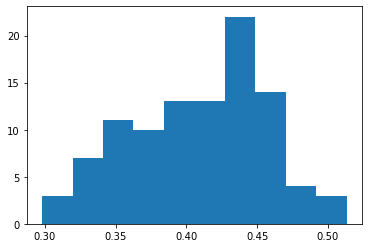

In [646]:
plt.hist(scores)

In [647]:
mean_squared_error(o_test, pl.predict(f_test), squared = False)

0.2684132907877855

### Final Model

In [648]:
as_is = ['STATE_RANKING', 'STATE_AUTOMATION']
standard_scale = ['TOT_EMP', 'A_MEAN', 'A_PCT10', 'A_PCT25',
       'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ECONOMIC_CONTRIBUTION']
ohe = ['Clean Title', 'Occupation', 'BIGGEST_STATE']
binarize = ['LARGE_SALARY']
states = ['Alabama', 'Alaska', 'Arizona',
        'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
        'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming']

preproc = ColumnTransformer(
transformers = [
    #('states', FunctionTransformer(lambda x: x/sum(features_state_df['TOT_EMP'])), states),
    #take the proportion of jobs in the US
    ('binarize', Binarizer(), binarize),
    ('as_is', FunctionTransformer(lambda x: x), as_is),
    ('standard', StandardScaler(), standard_scale),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ohe)
])

pl = Pipeline(steps = [('preprocessing', preproc), ('regressor', LinearRegression())])

In [649]:
f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

pl.fit(f_train, o_train)
pl.score(f_test, o_test)

0.512132295771798

In [650]:
mean_squared_error(o_test, pl.predict(f_test), squared = False)

0.25500664187457406

In [651]:
scores = []
for _ in range(100):
    f_train, f_test, o_train, o_test = train_test_split(features, outcome, test_size = 0.3)

    pl.fit(f_train, o_train)
    scores.append(pl.score(f_test, o_test))

(array([ 4.,  5.,  7., 13., 14., 17., 19., 12.,  7.,  2.]),
 array([0.29954703, 0.31998694, 0.34042685, 0.36086676, 0.38130667,
        0.40174658, 0.42218649, 0.4426264 , 0.46306631, 0.48350622,
        0.50394613]),
 <BarContainer object of 10 artists>)

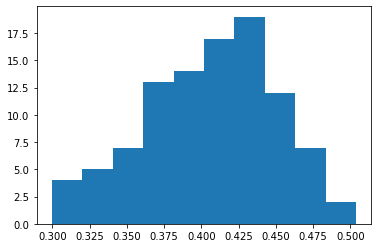

In [652]:
plt.hist(scores)